In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import fftpack

import utility_functions as fn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# reads from csv into a new dataframe
raw_weather = pd.read_csv('weather_raw.csv',index_col=1)

# reindexes by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['datetime']

# removes unused columns
raw_weather.drop(raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])],axis=1,inplace=True)

# renames columnds
raw_weather.columns = ['temp','t_min','t_max','pressure','humidity','wind','rain','snow','clouds']
raw_weather = raw_weather[['temp','t_min','t_max','pressure','humidity','wind','clouds','rain','snow']]

In [3]:
# drops duplicate rows
raw_weather.drop_duplicates(inplace=True)

In [4]:
# TEMPORARY bypass missing 2014-2015 data
weather = raw_weather.truncate('2016-01-01 00:00:00','2019-02-10 00:00:00')

In [5]:
# creates new index shifted by one position, used to calculate gap sizes
# this line could be based on integer indices of truncated weather index rather than hardcoded
offbyone = raw_weather.truncate('2015-12-31 22:00:00','2019-02-09 23:00:00')

# create bool column indicating if a time gap is greater than six hours
weather['impute_ok'] = weather.index - offbyone.index <= '06:00:00'

In [6]:
# reindexes to fill missing rows, for a total length of 27265
correct_dt = pd.DatetimeIndex(start='2016-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
weather = weather.reindex(index=correct_dt)

In [7]:
# fills gaps less than 6 hours with impute_ok = True
weather['impute_ok'].fillna(method='bfill',inplace=True)

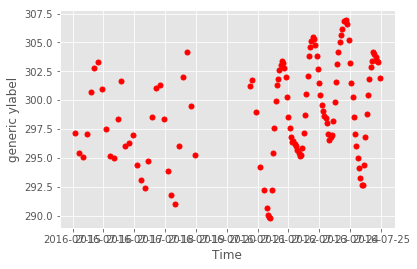

In [8]:
# removes weird wind outlier
weather['wind'] = weather['wind'].where(weather['wind'] < 20*weather['wind'].median())

# assigns NaN precip values to zero, this is an unconfirmed assumption
weather['rain'] = weather['rain'].replace(np.NaN,0)
weather['snow'] = weather['snow'].replace(np.NaN,0)

# sets nonsense zeroes in temp, pressure, and humidity to NaN
weather.iloc[:,[0,1,2,3,4]] = weather.iloc[:,[0,1,2,3,4]].replace(0,np.NaN)

fn.snapshotplot(weather,'temp','2016-07-15 00:00:00','2016-07-25 00:00:00')

In [9]:
# at this point, i want to simple impute only values that have impute_ok = True
weather.mask(weather['impute_ok']==True, weather.interpolate(method='time',limit=6), inplace=True)

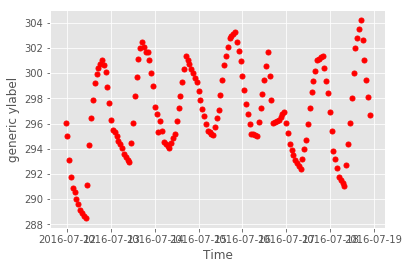

In [32]:
# plot over missing chunk to check that the simple impute has yielded expected results
fn.snapshotplot(weather,'temp','2016-07-15 00:00:00','2016-07-25 00:00:00')

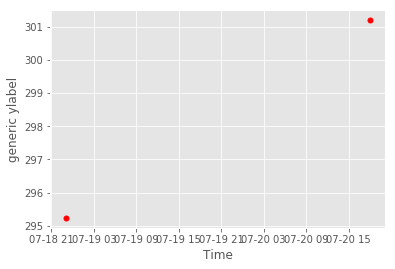

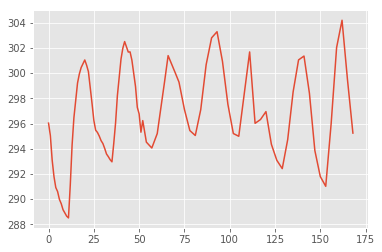

In [33]:
# fft imputation plan:
# create fft for 5 days preceding and 5 days after

fn.snapshotplot(weather,'temp','2016-07-11 23:00:00','2016-07-18 23:00:00')

fn.snapshotplot(weather,'temp','2016-07-18 23:00:00','2016-07-20 19:00:00')

fft = fftpack.fft(weather['temp'].loc['2016-07-11 23:00:00':'2016-07-18 23:00:00'])
ifft= fftpack.ifft(fft)
real = ifft.real

plt.plot(range(len(real)),real)

In [ ]:
# interpolates large segments using quadratic, ignores period :(
# weather = weather.interpolate(method='quadratic',limit=40)

fn.snapshotplot(weather,'temp','2016-07-17 00:00:00','2016-07-23 00:00:00')

# weather.isnull().sum()

In [ ]:
def hours_before(column,number):
    # column is a array of hourly indexed values, number is the number of columns to add
    # returns an array with the same index as 

    

In [ ]:
# USEFUL STUFF

# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)

In [ ]:
# concise = weather.drop(weather.columns[np.array([5,6,7,8,9,10,11,12,13,14])], axis=1)
# concise.to_csv('weather_clean.csv')